**Nama Anggota Kelompok :**


1. Risma Faoziya - 24060119120001
2. Doma Zaneta - 24060119140069
3. Gregorius Willy Adiguno - 24060119130076
4. Sekar Wangi Kusumastomo - 24060119120020
5. Agry Apri Astuti - 24060119120009

# **Algoritma *Support Vector Machine* untuk mendeteksi Diabetes Pima Indian**

## ***Load and Understanding Dataset***

### **Memuat *Dataset* Diabetes Pima Indians**

Dataset berisi 8 kolom atribut dan 1 kolom label yang berisi 2 kelas yaitu 1 dan 0. Angka 1 menandakan bahwa orang tersebut positif diabetes dan 0 menandakan sebaliknya. Terdapat 768 sampel yang merupakan 768 pasien perempuan keturunan suku Indian Pima.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQq0oaUe_pMurSVxA01cDOITZ5fRzOmsq_wDkeGq2mMBSq2nNVzdQ4W8TTwpWs5wQy2ZCrvm20ArEWj/pub?output=csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,627.000,50,1
1,1,85,66,29,0,26.6,351.000,31,0
2,8,183,64,0,0,23.3,672.000,32,1
3,1,89,66,23,94,28.1,167.000,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **Eksplorasi *Dataset***

In [ ]:
# Mengecek dimensi dataframe

df.shape

(768, 9)

*Output* di atas menunjukkan bahwa *dataset* terdiri atas 768 baris data dengan 9 kolom.

In [ ]:
data = df.copy()

## ***Data Preprocessing and Cleansing***

### ***Checking Nan Values***

In [ ]:
# Mengecek apakah ada nilai NaN

data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Semua data dalam dataset tidak ada yang bernilai NaN.

In [ ]:
# Mencari fitur-fitur kategorikal pada dataset

categorical_features = [
    features for features in data.columns if data[features].dtype == 'O']

print("Categorical features in dataset : ", categorical_features)
print("Number of categorical features  = ", len(categorical_features))

Categorical features in dataset :  []

Number of categorical features  =  0


*Output* di atas menunjukkan bahwa tidak ada data kategoris dalam dataset Diabetes Pima Indians. Oleh karena itu, tidak perlu dilakukan tahap *data encoding*

Hal paling penting selanjutnya adalah kita perlu mengecek apakah terdapat nilai-nilai yang hilang pada dataset serta apakah ada atribut yang bukan berisi bilangan numerik. Kita bisa melakukan ini dengan memanggil fungsi .info() pada dataframe.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 768 entries, 0 to 767

Data columns (total 9 columns):

 #   Column                    Non-Null Count  Dtype  

---  ------                    --------------  -----  

 0   Pregnancies               768 non-null    int64  

 1   Glucose                   768 non-null    int64  

 2   BloodPressure             768 non-null    int64  

 3   SkinThickness             768 non-null    int64  

 4   Insulin                   768 non-null    int64  

 5   BMI                       768 non-null    float64

 6   DiabetesPedigreeFunction  768 non-null    float64

 7   Age                       768 non-null    int64  

 8   Outcome                   768 non-null    int64  

dtypes: float64(2), int64(7)

memory usage: 54.1 KB


### **Deteksi dan Penanganan *Outliers***

Pendekatan deteksi *outliers* yang akan digunakan adalah dengan teknik matematika Interquartile Range (IQR). IQR adalah ukuran penyebaran statistik yang mengukur variabilitas data dan membagi data menjadi 4 bagian yang sama. Nilai-nilai yang memisahkan 4 bagian yang sama itu dikenal sebagai kuartil, yang mana terdapat kuartil pertama (Q1) yang merepresentasikan persentil 25 dari data, kuartil kedua (Q2) merepresentasikan persentil 50 dari data, dan kuartil ketiga (Q3) yang merepresentasikan persentil 75 dari data. Persamaan di bawah menunjukkan rumus untuk mencari IQR:

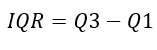

Deteksi *outliers* menggunakan pendekatan IQR dilakukan dengan mengurutkan data dari nilai terendah ke nilai tertinggi, kemudian mencari nilai Q1 dan Q3 dari data terurut, menghitung nilai IQR sesuai persamaan (i), kemudian mengecek semua data point, yang mana semua data point yang berada di bawah nilai lower bound (Q1-1.5 x IQR) atau di atas nilai upper bound (Q3+1.5 x IQR) merupakan *outliers*. Setelah menemukan semua *outliers* pada data, tahap pembersihan data dari *outliers* akan dilakukan. 

In [ ]:
# Fungsi untuk mendeteksi outliers
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    print('lower bound : ', lwr_bound, '; upper bound : ', upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

Jika semua outliers sudah berhasil ditemukan, maka selanjutnya data outliers akan ditangani dengan mengganti nilainya menjadi nilai sesuai dengan nilai persentil dari data yang telah ditentukan. Pada project ini, penulis menetapkan 2 persentil, yaitu Q1 yang merupakan persentil 10 dari data dan Q3 yang merupakan persentil 90 dari data. Outliers akan ditangani dengan aturan bahwa jika ada data yang nilainya berada di bawah Q1, maka akan diganti dengan nilai Q1, dan data yang nilainya berada di atas Q3, maka nilainya akan diganti dengan Q3. Berikut aplikasinya pada setiap fitur:

#### Mendeteksi *outliers* pada fitur Pregnancies

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Pregnancies'])

lower bound :  -6.5 ; upper bound :  13.5


[14, 14, 15, 17]

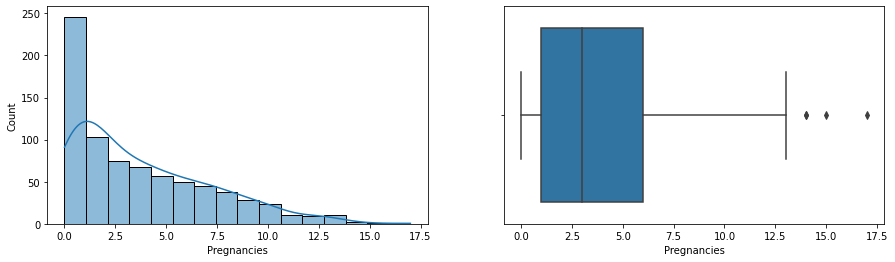

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Pregnancies",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Pregnancies', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_Pregnancies = sorted(df['Pregnancies'])
print(sorted_Pregnancies)

q1 = np.percentile(sorted_Pregnancies, 10)
q3 = np.percentile(sorted_Pregnancies, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['Pregnancies'] = np.where(df['Pregnancies']<q1, q1, df['Pregnancies'])
df['Pregnancies'] = np.where(df['Pregnancies']>q3, q3, df['Pregnancies'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Pregnancies'])

lower bound :  -6.5 ; upper bound :  13.5


[]

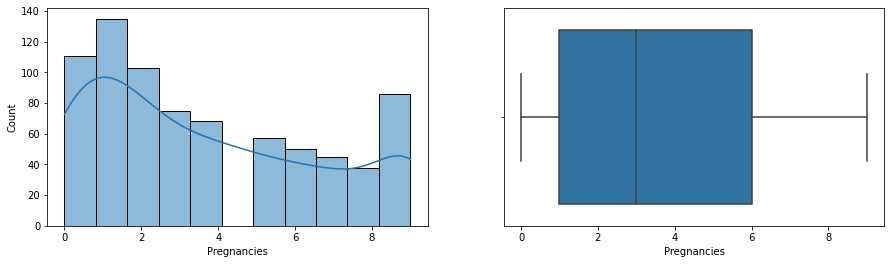

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Pregnancies",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Pregnancies', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur Glucose

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Glucose'])

lower bound :  37.125 ; upper bound :  202.125


[0, 0, 0, 0, 0]

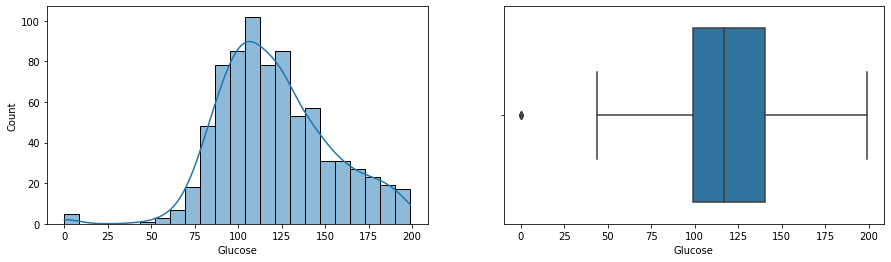

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Glucose",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Glucose', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_Glucose = sorted(df['Glucose'])
print(sorted_Glucose)

q1 = np.percentile(sorted_Glucose, 10)
q3 = np.percentile(sorted_Glucose, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['Glucose'] = np.where(df['Glucose']<q1, q1, df['Glucose'])
df['Glucose'] = np.where(df['Glucose']>q3, q3, df['Glucose'])

[0, 0, 0, 0, 0, 44, 56, 57, 57, 61, 62, 65, 67, 68, 68, 68, 71, 71, 71, 71, 72, 73, 73, 73, 74, 74, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 78, 78, 79, 79, 79, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 82, 82, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 1

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Glucose'])

lower bound :  37.125 ; upper bound :  202.125


[]

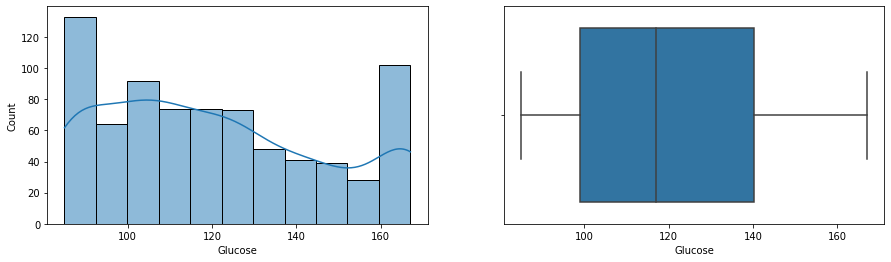

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Glucose",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Glucose', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur BloodPressure

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['BloodPressure'])

lower bound :  35.0 ; upper bound :  107.0


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 24,
 30,
 30,
 108,
 108,
 110,
 110,
 110,
 114,
 122]

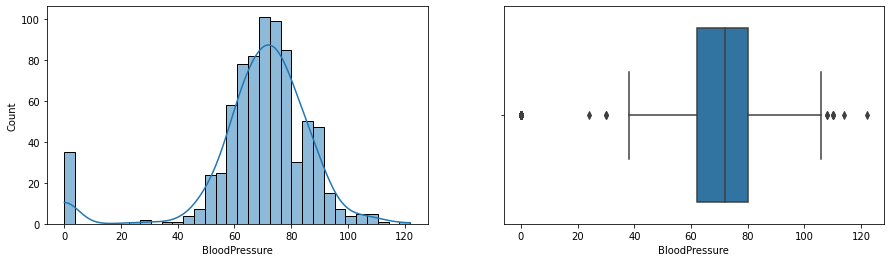

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="BloodPressure",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='BloodPressure', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_BloodPressure = sorted(df['BloodPressure'])
print(sorted_BloodPressure)

q1 = np.percentile(sorted_BloodPressure, 10)
q3 = np.percentile(sorted_BloodPressure, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['BloodPressure'] = np.where(df['BloodPressure']<q1, q1, df['BloodPressure'])
df['BloodPressure'] = np.where(df['BloodPressure']>q3, q3, df['BloodPressure'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 30, 30, 38, 40, 44, 44, 44, 44, 46, 46, 48, 48, 48, 48, 48, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['BloodPressure'])

lower bound :  35.0 ; upper bound :  107.0


[]

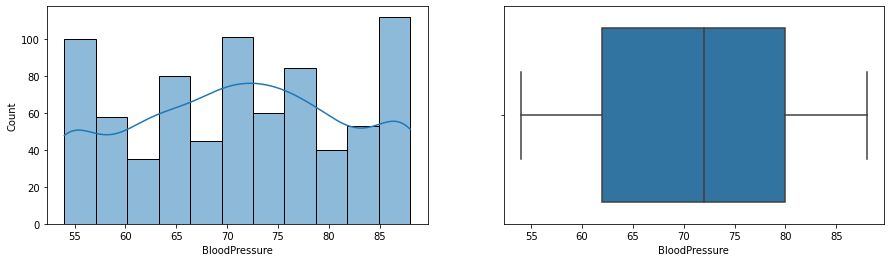

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="BloodPressure",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='BloodPressure', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur SkinThickness

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['SkinThickness'])

lower bound :  -48.0 ; upper bound :  80.0


[99]

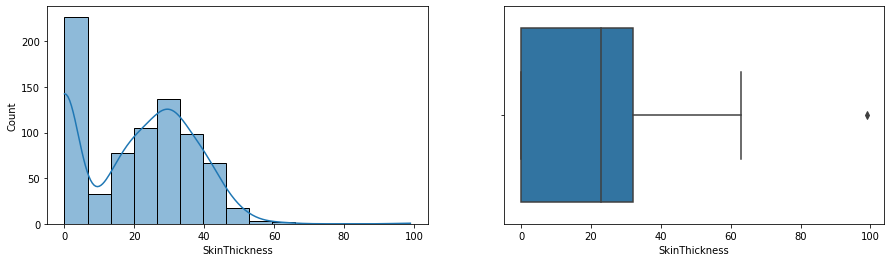

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="SkinThickness",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='SkinThickness', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_SkinThickness = sorted(df['SkinThickness'])
print(sorted_SkinThickness)

q1 = np.percentile(sorted_SkinThickness, 10)
q3 = np.percentile(sorted_SkinThickness, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['SkinThickness'] = np.where(df['SkinThickness']<q1, q1, df['SkinThickness'])
df['SkinThickness'] = np.where(df['SkinThickness']>q3, q3, df['SkinThickness'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['SkinThickness'])

lower bound :  -48.0 ; upper bound :  80.0


[]

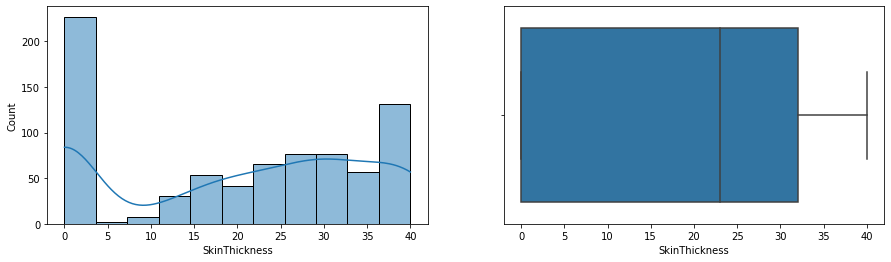

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="SkinThickness",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='SkinThickness', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur Insulin

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Insulin'])

lower bound :  -190.875 ; upper bound :  318.125


[321,
 325,
 325,
 325,
 326,
 328,
 330,
 335,
 342,
 360,
 370,
 375,
 387,
 392,
 402,
 415,
 440,
 465,
 474,
 478,
 480,
 480,
 485,
 495,
 495,
 510,
 540,
 543,
 545,
 579,
 600,
 680,
 744,
 846]

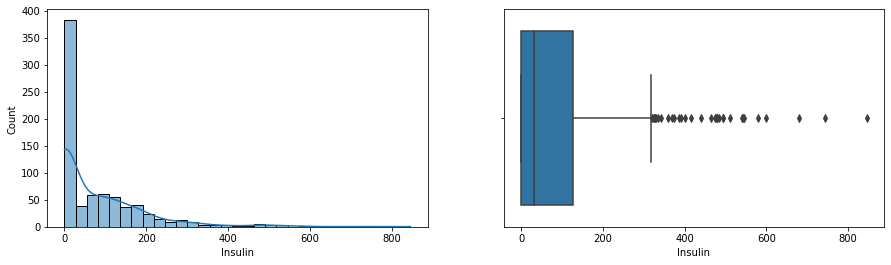

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Insulin",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Insulin', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_Insulin = sorted(df['Insulin'])
print(sorted_Insulin)

q1 = np.percentile(sorted_Insulin, 10)
q3 = np.percentile(sorted_Insulin, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['Insulin'] = np.where(df['Insulin']<q1, q1, df['Insulin'])
df['Insulin'] = np.where(df['Insulin']>q3, q3, df['Insulin'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Insulin'])

lower bound :  -190.875 ; upper bound :  318.125


[]

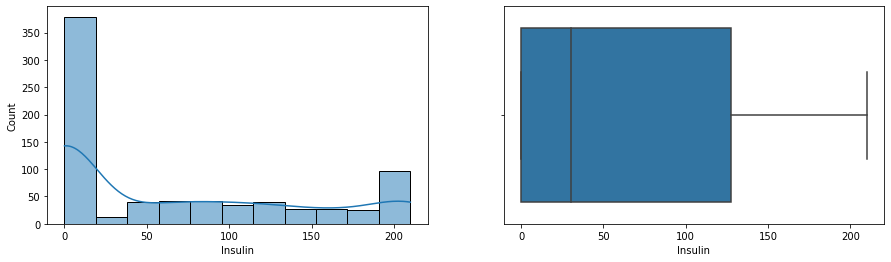

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Insulin",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Insulin', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur BMI

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['BMI'])

lower bound :  13.35 ; upper bound :  50.550000000000004


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 52.3,
 52.3,
 52.9,
 53.2,
 55.0,
 57.3,
 59.4,
 67.1]

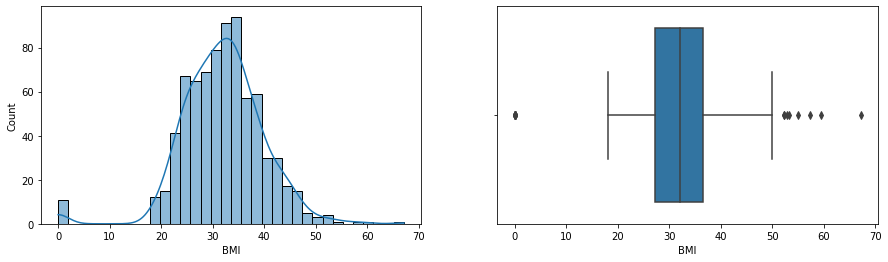

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="BMI",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='BMI', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_BMI = sorted(df['BMI'])
print(sorted_BMI)

q1 = np.percentile(sorted_BMI, 10)
q3 = np.percentile(sorted_BMI, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['BMI'] = np.where(df['BMI']<q1, q1, df['BMI'])
df['BMI'] = np.where(df['BMI']>q3, q3, df['BMI'])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.2, 18.2, 18.2, 18.4, 19.1, 19.3, 19.4, 19.5, 19.5, 19.6, 19.6, 19.6, 19.9, 20.0, 20.1, 20.4, 20.4, 20.8, 20.8, 21.0, 21.0, 21.1, 21.1, 21.1, 21.1, 21.2, 21.7, 21.8, 21.8, 21.8, 21.8, 21.8, 21.9, 21.9, 21.9, 22.1, 22.1, 22.2, 22.2, 22.3, 22.4, 22.4, 22.5, 22.5, 22.5, 22.6, 22.6, 22.7, 22.9, 22.9, 23.0, 23.0, 23.1, 23.1, 23.1, 23.1, 23.2, 23.2, 23.2, 23.3, 23.3, 23.4, 23.5, 23.5, 23.5, 23.6, 23.6, 23.6, 23.7, 23.7, 23.8, 23.8, 23.9, 23.9, 24.0, 24.0, 24.0, 24.0, 24.1, 24.2, 24.2, 24.2, 24.2, 24.2, 24.2, 24.3, 24.3, 24.3, 24.3, 24.4, 24.4, 24.4, 24.5, 24.6, 24.6, 24.6, 24.6, 24.7, 24.7, 24.7, 24.7, 24.7, 24.8, 24.8, 24.8, 24.9, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.1, 25.1, 25.1, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.3, 25.3, 25.4, 25.4, 25.4, 25.4, 25.5, 25.5, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.8, 25.8, 25.9, 25.9, 25.9, 25.9, 25.9, 25.9, 25.9, 26.0, 26.0, 26.0, 26.0, 26.1, 26.1, 26.1, 26.2, 26.2, 26.2, 26.2, 26.3, 26.4, 26

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['BMI'])

lower bound :  13.35 ; upper bound :  50.550000000000004


[]

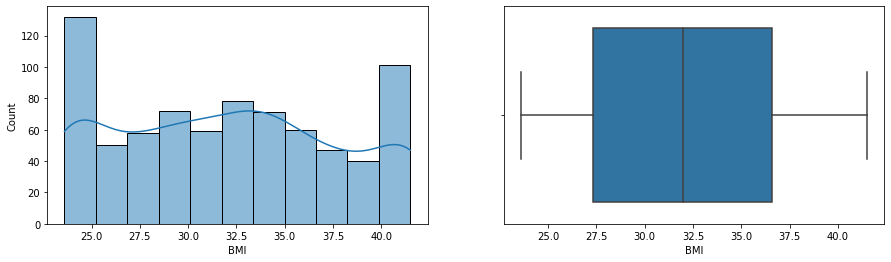

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="BMI",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='BMI', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur DiabetesPedigreeFunction

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['DiabetesPedigreeFunction'])

lower bound :  -378.375 ; upper bound :  1070.625


[]

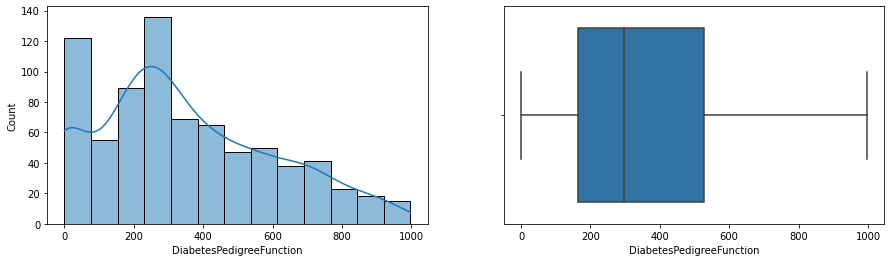

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="DiabetesPedigreeFunction",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='DiabetesPedigreeFunction', data=df)
plt.show()

#### Mendeteksi *outliers* pada fitur Age

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Age'])

lower bound :  -1.5 ; upper bound :  66.5


[67, 67, 67, 68, 69, 69, 70, 72, 81]

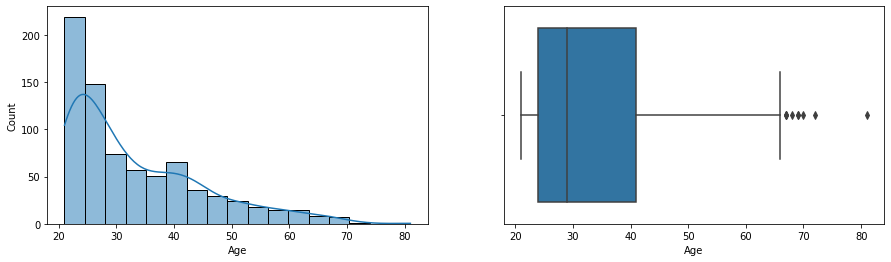

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Age",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Age', data=df)
plt.show()

In [ ]:
# Mengganti nilai data-data outliers ke dalam nilai sesuai dengan range percentile 1 dan 3
sorted_Age = sorted(df['Age'])
print(sorted_Age)

q1 = np.percentile(sorted_Age, 10)
q3 = np.percentile(sorted_Age, 90)
print('q1 = ', q1, '; q3 = ', q3)

df['Age'] = np.where(df['Age']<q1, q1, df['Age'])
df['Age'] = np.where(df['Age']>q3, q3, df['Age'])

[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,

In [ ]:
# Mendeteksi apakah ada outliers pada data
# menggunakan fungsi detect_outliers_iqr
detect_outliers_iqr(df['Age'])

lower bound :  -1.5 ; upper bound :  66.5


[]

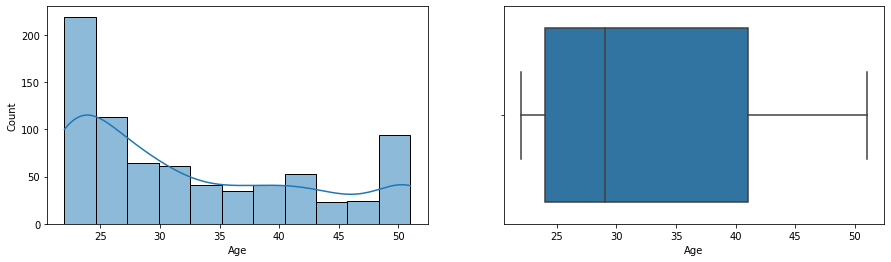

In [ ]:
# Visualisasi
fig = plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
sns.histplot(data=df, x="Age",kde=True)

plt.subplot(1,2,2)
sns.boxplot(x='Age', data=df)
plt.show()

Output dari fungsi info() menunjukkan bahwa semua atribut nilainya lengkap, dan juga nilai-nilai dari tiap kolom memiliki tipe data numerik yaitu int64 dan float64.
Pada tahap ini data sudah bisa dipakai untuk pelatihan model.

In [ ]:
df.shape

(768, 9)

### **Mencari Korelasi Antarfitur**

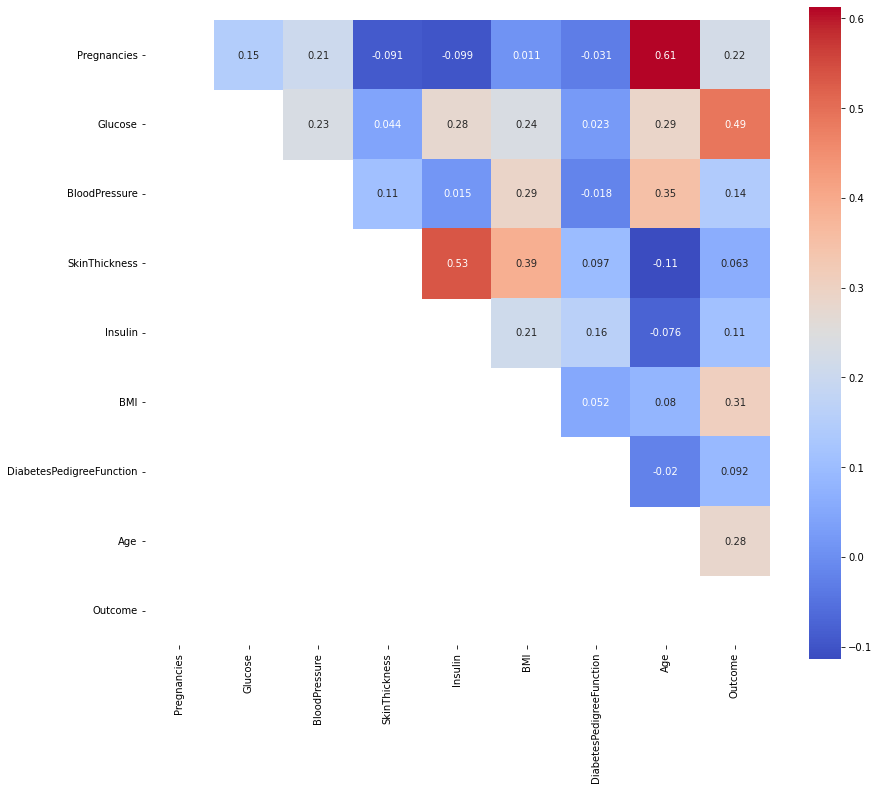

In [ ]:
plt.figure(figsize=(14, 12))
mask = np.tril(df.corr())
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.2g', square=True, mask=mask);

### **Memisahkan Atribut (x) dan Label (y) Pada Dataframe df**

In [ ]:
# memisahkan atribut pada dataset dan menyimpannya pada sebuah variabel
x = df[df.columns[:8]]

# memisahkan label pada dataset dan menyimpannya pada sebuah variabel
y = df['Outcome']

Jika kita lihat, nilai-nilai pada dataset memiliki skala yang berbeda. Contohnya pada kolom Glucose dan kolom Diabetes Pedigree Function. Kita perlu mengubah nilai-nilai dari setiap atribut berada pada skala yang sama. Kita dapat mencoba menggunakan standarisasi dengan fungsi StandardScaler() dari SKLearn.
https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

### **Standarisasi Data** (Dataset diabetes merupakan data berdistribusi kuantitas normal)

In [ ]:
from sklearn.preprocessing import StandardScaler

# standarisasi nilai-nilai dari dataset
scaler = StandardScaler()
scaler.fit(x)
scaled_x = scaler.transform(x)

## ***Feature Extraction***

### **Mengaplikasikan PCA**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_x)

In [ ]:
pca_data

array([[ 1.71636781,  0.78402122],
       [-1.62245774, -0.19809447],
       [-0.21481999,  1.77378136],
       ...,
       [-0.14350661,  0.04299924],
       [-0.81698128,  1.29197719],
       [-1.37518502, -0.71915099]])

### **Memisahkan Data *Training* dan *Data Testing***

Setelah atribut dan label dipisah, kita bisa memisahkan data untuk training dan testing menggunakan fungsi .train_test_split().

#### Pemisahan *Scaled Data* Menjadi Data *Training* dan *Testing* tanpa PCA

In [ ]:
from sklearn.model_selection import train_test_split

# memisahkan data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    scaled_x, y, test_size=0.1, random_state=0)

#### Pemisahan *Scaled Data* Menjadi Data *Training* dan *Testing* dengan PCA

In [ ]:
from sklearn.model_selection import train_test_split

# memisahkan data untuk training dan testing
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(
    pca_data, y, test_size=0.1, random_state=0)

## **Pembangunan Model dan Evaluasi**

Pada tahap ini dataset akan dicoba dilatih dengan beberapa algoritma klasifikasi, kemudian model klasifikasi yang dihasilkan dari setiap algoritma akan diuji menggunakan metode k-folds cross validation untuk menemukan algoritma terbaik dengan ukuran akurasi. Algoritma klasifikasi yang digunakan, antara lain Decision Tree Classifier, Random Forest Classifier, SVM, K-Nearest Neighbors Classifier, XGB Classifier, dan Bagging Classifier.

In [ ]:
# Import library berisi algoritma klasifikasi yang akan digunakan
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

# Mendefinisikan array kosong
models = []

# Membuat array asosiatif berisi nama algoritma dan algoritma klasifikasinya
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('SVM', SVC(kernel='linear')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 7, metric = 'euclidean')))
models.append(('XGB Classifier', XGBClassifier()))
models.append(('Bagging Classifier', BaggingClassifier()))

In [ ]:
# Mendefinisikan seed dan scoring yang digunakan untuk menguji model dengan
# validation data
seed = 7
scoring = 'accuracy'

#### *K-Fold Cross Validation* tanpa PCA

In [ ]:
# Import library yang dibutuhkan
from sklearn import model_selection

results = []
names = []

# Membagi data menjadi training dan validation set menggunakan k-fold cross 
# validation, dengan k = 10
for name, model in models:
  kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
  
  # Menguji akurasi dari masing-masing model menggunakan validation data
  cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

Decision Tree : 0.674596 (0.059190)

Random Forest : 0.758385 (0.029090)

SVM : 0.751118 (0.029944)

KNN : 0.736605 (0.022341)

XGB Classifier : 0.759917 (0.045700)

Bagging Classifier : 0.745342 (0.051261)


*Output* di atas menunjukkan bahwa algoritma SVM, XGB Classifier, dan Random Forest merupakan 3 algoritma dengan kinerja terbaik, diukur dari pengujian dengan *validation data*.

In [ ]:
# Import library untuk mengevaluasi algoritma
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb_model = XGBClassifier()

xgb_model.fit(X_train, y_train)
predictions_xgb = xgb_model.predict(X_test)

print('akurasi pada testing data : ', accuracy_score(y_test, predictions_xgb))
print('confusion matrix : \n', confusion_matrix(y_test, predictions_xgb))
print('classification report : \n', classification_report(y_test, predictions_xgb))

akurasi pada testing data :  0.7922077922077922

confusion matrix : 

 [[44  7]

 [ 9 17]]

classification report : 

               precision    recall  f1-score   support



           0       0.83      0.86      0.85        51

           1       0.71      0.65      0.68        26



    accuracy                           0.79        77

   macro avg       0.77      0.76      0.76        77

weighted avg       0.79      0.79      0.79        77




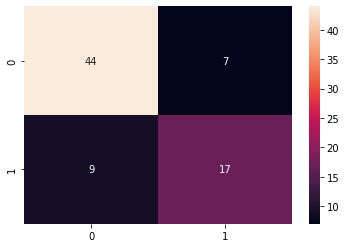

In [ ]:
# Visualisasi confusion matrix algoritma random forest
cm_xgb = confusion_matrix(y_test, predictions_xgb)
sns.heatmap(cm_xgb, annot=True)

In [ ]:
# Import library untuk mengevaluasi algoritma
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_test)

print('akurasi pada testing data : ', accuracy_score(y_test, predictions_rf))
print('confusion matrix : \n', confusion_matrix(y_test, predictions_rf))
print('classification report : \n', classification_report(y_test, predictions_rf))

akurasi pada testing data :  0.8311688311688312

confusion matrix : 

 [[45  6]

 [ 7 19]]

classification report : 

               precision    recall  f1-score   support



           0       0.87      0.88      0.87        51

           1       0.76      0.73      0.75        26



    accuracy                           0.83        77

   macro avg       0.81      0.81      0.81        77

weighted avg       0.83      0.83      0.83        77




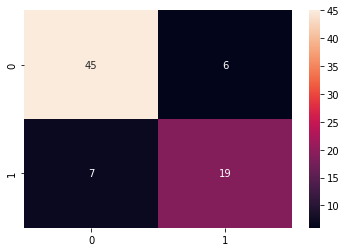

In [ ]:
# Visualisasi confusion matrix algoritma random forest
cm_rf = confusion_matrix(y_test, predictions_rf)
sns.heatmap(cm_rf, annot=True)

In [ ]:
# Import library untuk mengevaluasi algoritma
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)
predictions_svm = svm_model.predict(X_test)

print('akurasi pada testing data : ', accuracy_score(y_test, predictions_svm))
print('confusion matrix : \n', confusion_matrix(y_test, predictions_svm))
print('classification report : \n', classification_report(y_test, predictions_svm))

akurasi pada testing data :  0.8311688311688312

confusion matrix : 

 [[46  5]

 [ 8 18]]

classification report : 

               precision    recall  f1-score   support



           0       0.85      0.90      0.88        51

           1       0.78      0.69      0.73        26



    accuracy                           0.83        77

   macro avg       0.82      0.80      0.81        77

weighted avg       0.83      0.83      0.83        77




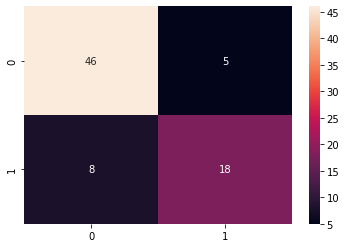

In [ ]:
# Visualisasi confusion matrix algoritma random forest
cm_svm = confusion_matrix(y_test, predictions_svm)
sns.heatmap(cm_svm, annot=True)

**Kesimpulan :**

Hasil pengujian model klasifikasi dengan *testing data* tanpa PCA menunjukkan bahwa algoritma SVM dan Random Forest menghasilkan model klasifikasi dengan kinerja terbaik untuk dataset diabetes pima indians.

#### *K-Fold Cross Validation* dengan PCA

In [ ]:
# Import library yang dibutuhkan
from sklearn import model_selection

results = []
names = []

# Membagi data menjadi training dan validation set menggunakan k-fold cross 
# validation, dengan k = 10
for name, model in models:
  kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
  
  # Menguji akurasi dari masing-masing model menggunakan validation data
  cv_results = model_selection.cross_val_score(model, x_train_pca, y_train_pca, cv=kfold, scoring=scoring)
  results.append(cv_results)
  msg = "%s : %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

Decision Tree : 0.642609 (0.053369)

Random Forest : 0.671615 (0.060286)

SVM : 0.710725 (0.050568)

KNN : 0.658613 (0.057246)

XGB Classifier : 0.667308 (0.063354)

Bagging Classifier : 0.652836 (0.057035)


*Output* di atas menunjukkan bahwa algoritma SVM, XGB Classifier, dan Random Forest merupakan 3 algoritma dengan kinerja terbaik, diukur dari pengujian dengan *validation data*.

In [ ]:
# Import library untuk mengevaluasi algoritma
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb_model = XGBClassifier()

xgb_model.fit(x_train_pca, y_train_pca)
predictions_xgb_pca = xgb_model.predict(x_test_pca)

print('akurasi pada testing data : ', accuracy_score(y_test_pca, predictions_xgb_pca))
print('confusion matrix : \n', confusion_matrix(y_test_pca, predictions_xgb_pca))
print('classification report : \n', classification_report(y_test_pca, predictions_xgb_pca))

akurasi pada testing data :  0.6883116883116883

confusion matrix : 

 [[41 10]

 [14 12]]

classification report : 

               precision    recall  f1-score   support



           0       0.75      0.80      0.77        51

           1       0.55      0.46      0.50        26



    accuracy                           0.69        77

   macro avg       0.65      0.63      0.64        77

weighted avg       0.68      0.69      0.68        77




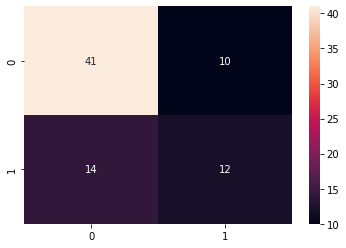

In [ ]:
# Visualisasi confusion matrix algoritma xgb
cm_xgb_pca = confusion_matrix(y_test, predictions_xgb_pca)
sns.heatmap(cm_xgb_pca, annot=True)

In [ ]:
# Import library untuk mengevaluasi algoritma
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rf_model = RandomForestClassifier()

rf_model.fit(x_train_pca, y_train_pca)
predictions_rf_pca = rf_model.predict(x_test_pca)

print('akurasi pada testing data : ', accuracy_score(y_test_pca, predictions_rf_pca))
print('confusion matrix : \n', confusion_matrix(y_test_pca, predictions_rf_pca))
print('classification report : \n', classification_report(y_test_pca, predictions_rf_pca))

akurasi pada testing data :  0.7012987012987013

confusion matrix : 

 [[40 11]

 [12 14]]

classification report : 

               precision    recall  f1-score   support



           0       0.77      0.78      0.78        51

           1       0.56      0.54      0.55        26



    accuracy                           0.70        77

   macro avg       0.66      0.66      0.66        77

weighted avg       0.70      0.70      0.70        77




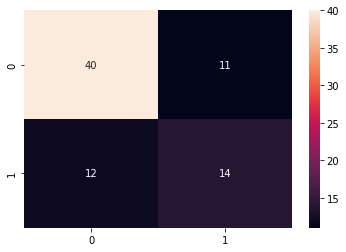

In [ ]:
# Visualisasi confusion matrix algoritma random forest
cm_rf_pca = confusion_matrix(y_test, predictions_rf_pca)
sns.heatmap(cm_rf_pca, annot=True)

In [ ]:
# Import library untuk mengevaluasi algoritma
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svm_model = SVC(kernel='linear')

svm_model.fit(x_train_pca, y_train_pca)
predictions_svm_pca = svm_model.predict(x_test_pca)

print('akurasi pada testing data : ', accuracy_score(y_test_pca, predictions_svm_pca))
print('confusion matrix : \n', confusion_matrix(y_test_pca, predictions_svm_pca))
print('classification report : \n', classification_report(y_test_pca, predictions_svm_pca))

akurasi pada testing data :  0.7142857142857143

confusion matrix : 

 [[43  8]

 [14 12]]

classification report : 

               precision    recall  f1-score   support



           0       0.75      0.84      0.80        51

           1       0.60      0.46      0.52        26



    accuracy                           0.71        77

   macro avg       0.68      0.65      0.66        77

weighted avg       0.70      0.71      0.70        77




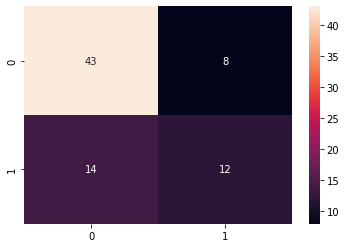

In [ ]:
# Visualisasi confusion matrix algoritma SVM
cm_svm_pca = confusion_matrix(y_test, predictions_svm_pca)
sns.heatmap(cm_svm_pca, annot=True)

**Kesimpulan :**

Hasil pengujian model klasifikasi dengan *testing data* dengan PCA menunjukkan bahwa algoritma SVM enghasilkan model klasifikasi dengan kinerja terbaik untuk dataset diabetes pima indians.

## **Visualisasi**

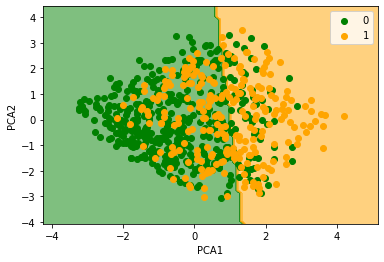

In [ ]:
from matplotlib.colors import ListedColormap

x_set, y_set = x_train_pca, y_train_pca

# Membuat grid kotak seperti Excel
x1, x2 = np.meshgrid(np.arange(start = x_set[:,0].min()-1, stop = x_set[:,0].max()+1, step = 0.1),
                     np.arange(start = x_set[:,1].min()-1, stop = x_set[:,1].max()+1, step = 0.1))

plt.contourf(x1, x2, svm_model.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape), 
            alpha = 0.5, cmap = ListedColormap(('green', 'orange')))

for i, j in enumerate(np.unique(y_set)):
  plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],
              c = ListedColormap(('green', 'orange'))(i), label = j)
  
  plt.xlabel('PCA1')
  plt.ylabel('PCA2')
  plt.legend()